In [ ]:
import pickle
import pandas as pd
import datetime as dt
import requests

import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt

from scipy.stats import nbinom
from scipy.stats import rv_discrete
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
import seaborn as sns
from sklearn.metrics import accuracy_score

import sklearn
from sklearn import model_selection
from datetime import datetime, timedelta
from sklearn.model_selection import GroupShuffleSplit
from scipy.optimize import minimize
import scipy.interpolate
from sklearn.metrics import mean_absolute_error

import cfbd
from cfbd.rest import ApiException

import pytz
from datetime import datetime, time
from timezonefinder import TimezoneFinder
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import set_with_dataframe


In [ ]:
cd C:\Users\Nolanator\Documents\College Football

In [ ]:
# Your API Key
api_key = 'EvAfgJ4sLdKNrQf9uDQFCFl+iZWPKE8N8l7vv2ENWmONMY/H7T8VafU6n/nctXat'

# Set the configuration
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'Bearer ' + api_key
api_client = cfbd.ApiClient(configuration)

In [ ]:
# Now create an instance of the API with this configuration and call it
api_instance = cfbd.GamesApi(api_client)
teams_api_instance = cfbd.TeamsApi(api_client)

In [ ]:
year = 2024
# Retrieve regular season games
regular_season_games = api_instance.get_games(year=year, season_type='regular')

In [ ]:
try:
    year = 2024
    # Retrieve regular season games
    regular_season_games = api_instance.get_games(year=year, season_type='regular')
    # Retrieve bowl games
    playoff_games = api_instance.get_games(year=year, season_type='postseason', week=1)

    # Retrieve all FBS teams
    fbs_teams = teams_api_instance.get_fbs_teams(year=year)
    fbs_team_ids = set([team.id for team in fbs_teams])

    # Filter for games where both teams are in FBS
    div1_playoff_games = [game for game in playoff_games if game.home_id in fbs_team_ids and game.away_id in fbs_team_ids]

    games = regular_season_games + div1_playoff_games


except ApiException as e:
    print("Exception when calling GamesApi->get_games: %s\n" % e)

In [ ]:
df_priors_2024=pd.read_csv("C:/Users/Nolanator/Documents/College Football/CFB_Priors_2024.csv",  sep=",", encoding='Latin-1')
df_priors_2024.columns=["Team", "sUPRE"]


df_dict = pd.read_csv("C:/Users/Nolanator/Documents/College Football/College_dict_Nolan.csv",  sep=",", encoding='Latin-1',header=None)
df_dict.columns=['team','team_code']
df_dict["team"] = df_dict["team"].str.upper()

In [ ]:
lamb = 4
HFA_base=2.3
window_length  =1
window_length_OLD =14
lamb_old=4

In [ ]:
# Create a list of dictionaries based on the `games` list
data = []
for game in games:
    if game.season_type == 'postseason':
        game_date = pd.to_datetime(game.start_date).tz_localize(None)
        cutoff_date_1 = pd.to_datetime('2024-12-23')
        cutoff_date_2 = pd.to_datetime('2025-01-04')
        cutoff_date_3 = pd.to_datetime('2025-01-12')
        if game_date > cutoff_date_3:
            week = 19
        elif game_date > cutoff_date_2:
            week = 18
        elif game_date > cutoff_date_1:
            week = 17
        else:
            week = 16
    else:
        week = game.week
    
    data.append({
        'id': game.id,
        'season': game.season,
        'week': week,
        'season_type': game.season_type,
        'start_date': game.start_date,
        'neutral_site': game.neutral_site,
        'conference_game': game.conference_game,
        'venue_id': game.venue_id,
        'venue': game.venue,
        'home_id': game.home_id,
        'home_team': game.home_team,
        'home_conference': game.home_conference,
        'home_division': game.home_division,
        'home_points': game.home_points,
        'away_id': game.away_id,
        'away_team': game.away_team,
        'away_conference': game.away_conference,
        'away_division': game.away_division,
        'away_points': game.away_points
    })

# Rest of the code remains the same
df = pd.DataFrame(data)
df["home_team"] = df["home_team"].str.upper()
df["away_team"] = df["away_team"].str.upper()
team_correct_dict_2024 = {"SAN JOSÃ© STATE":"SAN JOSE STATE", "HAWAI'I":"HAWAII", "SAN JOSÉ STATE":"SAN JOSE STATE",
                         "NORTHERN ILLINOIS":"NORTH ILLINOIS", "EASTERN MICHIGAN":"EAST MICHIGAN"}
df["home_team"] = np.where(df["home_team"].isin(team_correct_dict_2024.keys())  , df["home_team"].map(team_correct_dict_2024)    , df["home_team"] )
df["away_team"] = np.where(df["away_team"].isin(team_correct_dict_2024.keys())  , df["away_team"].map(team_correct_dict_2024)    , df["away_team"] )
df["start_date"] = pd.to_datetime(df["start_date"])

In [ ]:
df[df["week"]==16].shape

In [ ]:
df["week"]= np.where(df["id"].isin([401635525,401643696]), 0, df["week"])
list_cancelled_games=[401640992]
df=df[~df["id"].isin(list_cancelled_games)]

In [ ]:
# Combine home and away games for each team into a single dataframe
home_games = df[['start_date', 'home_team']].rename(columns={'home_team': 'team'})
away_games = df[['start_date', 'away_team']].rename(columns={'away_team': 'team'})

# Concatenate the home and away games into a single dataframe for each team
all_games = pd.concat([home_games, away_games])


all_games.sort_values(by=['team', 'start_date'], inplace=True)

# Calculate the difference in days between consecutive games
all_games['rest_days'] = all_games.groupby('team')['start_date'].diff().dt.days

# Merge the rest days back to the original dataframe for home teams
df = pd.merge(df, all_games[['team', 'start_date', 'rest_days']], 
                                  how='left', left_on=['home_team', 'start_date'], 
                                  right_on=['team', 'start_date'])

# Rename the 'rest_days' column to 'home_team_rest_days'
df.rename(columns={'rest_days': 'home_team_rest_days'}, inplace=True)

# Drop 'team_code' if it exists after the first merge
if 'team' in df.columns:
    df.drop(columns=['team'], inplace=True)

# Merge the rest days back to the original dataframe for away teams
df = pd.merge(df, all_games[['team', 'start_date', 'rest_days']], 
                                  how='left', left_on=['away_team', 'start_date'], 
                                  right_on=['team', 'start_date'])

# Rename the 'rest_days' column to 'away_team_rest_days'
df.rename(columns={'rest_days': 'away_team_rest_days'}, inplace=True)

# Drop 'team_code' if it exists after the second merge
if 'team' in df.columns:
    df.drop(columns=['team'], inplace=True)

# Fill NaN values with a default rest day value if it's the team's first game
df['home_team_rest_days'].fillna(7, inplace=True)
df['away_team_rest_days'].fillna(7, inplace=True)

df["home_rest_days_adv"] = df['home_team_rest_days']-df['away_team_rest_days']
df["home_rest_days_adv"]=df["home_rest_days_adv"].clip(upper=10)
df["home_rest_days_adv"]=df["home_rest_days_adv"].clip(lower=-8)

# Final DataFrame with new columns
print(df[['start_date', 'home_team', 'away_team', 'home_team_rest_days', 'away_team_rest_days']])

In [743]:
# df_coll_impt_2024[df_coll_impt_2024["id"]==401640998][["id", "week", "home_team", "away_team"]]

In [744]:
# df_coll_impt_mdl_2024[df_coll_impt_mdl_2024["id"]==401640998][["id", "week", "home_team_code", "away_team_code"]]

In [745]:
df.tail(4)

,id,season,week,season_type,start_date,neutral_site,conference_game,venue_id,venue,home_id,home_team,home_conference,home_division,home_points,away_id,away_team,away_conference,away_division,away_points,home_team_rest_days,away_team_rest_days,home_rest_days_adv
3788,401677108,2024,18,postseason,2025-01-04 16:00:00+00:00,True,False,4779.0,Thomas A. Robinson National Stadium,2335,LIBERTY,Conference USA,fbs,7.0,2084,BUFFALO,Mid-American,fbs,26.0,35.0,38.0,-3.0
3789,401677189,2024,18,postseason,2025-01-10 00:30:00+00:00,True,False,3948.0,Hard Rock Stadium,213,PENN STATE,Big Ten,fbs,24.0,87,NOTRE DAME,FBS Independents,fbs,27.0,9.0,7.0,2.0
3790,401677191,2024,18,postseason,2025-01-11 00:30:00+00:00,True,False,3687.0,AT&T Stadium,251,TEXAS,SEC,fbs,14.0,194,OHIO STATE,Big Ten,fbs,28.0,9.0,9.0,0.0
3791,401677192,2024,19,postseason,2025-01-21 00:30:00+00:00,True,False,5348.0,Mercedes-Benz Stadium,87,NOTRE DAME,FBS Independents,fbs,23.0,194,OHIO STATE,Big Ten,fbs,34.0,11.0,10.0,1.0


In [ ]:
df_coll_impt_2024=pd.merge(left=df, right=df_dict, left_on='home_team', right_on='team', how='left')
df_coll_impt_2024[~df_coll_impt_2024["team_code"].isnull()].reset_index(drop=True)
df_coll_impt_2024 = pd.merge(left=df_coll_impt_2024, right=df_dict, left_on='away_team', right_on='team', how='left')
df_coll_impt_mdl_2024 = df_coll_impt_2024[["start_date","id","week","venue", "team_code_x", "team_code_y", "home_points","away_points","neutral_site","home_rest_days_adv"]]
df_coll_impt_mdl_2024.columns=["date","id","week","venue", "home_team_code","away_team_code", "home_points","away_points","neutral_site","home_rest_days_adv"]
df_coll_impt_mdl_2024["home_team_code"] = df_coll_impt_mdl_2024["home_team_code"]
df_coll_impt_mdl_2024["away_team_code"] = df_coll_impt_mdl_2024["away_team_code"]
df_coll_impt_mdl_2024=pd.merge(left=df_coll_impt_mdl_2024, right=df_priors_2024[["Team","sUPRE"]] , left_on='home_team_code', right_on='Team', how='left')
df_coll_impt_mdl_2024=pd.merge(left=df_coll_impt_mdl_2024, right=df_priors_2024[["Team","sUPRE"]] , left_on='away_team_code', right_on='Team', how='left')
df_coll_impt_mdl_2024.drop(columns=['Team_x', 'Team_y'], inplace=True)

df_coll_impt_mdl_2024.dropna(subset=["home_team_code","away_team_code"],inplace=True)
df_coll_impt_mdl_2024["actual_spread"] = df_coll_impt_mdl_2024["home_points"] - df_coll_impt_mdl_2024["away_points"]
df_coll_impt_mdl_2024.rename(columns={"sUPRE_x":"home_team_preseason_rating", "sUPRE_y":"away_team_preseason_rating"},inplace=True)

In [ ]:
df_coll_impt_mdl_2024.tail(5)

In [ ]:
df_coll_impt_mdl_2024["neutral_site"] = np.where((df_coll_impt_mdl_2024["venue"]=="Lanny and Sharon Martin Stadium")&(df_coll_impt_mdl_2024["home_team_code"]=="NW"),False,df_coll_impt_mdl_2024["neutral_site"])

df_coll_impt_mdl_2024["neutral_site"] = np.where((df_coll_impt_mdl_2024["home_team_code"]=="FIU")&(df_coll_impt_mdl_2024["venue"]=="Pitbull Stadium"),False,df_coll_impt_mdl_2024["neutral_site"])

df_coll_impt_mdl_2024["neutral_site"] = np.where((df_coll_impt_mdl_2024["home_team_code"]=="KU")&(df_coll_impt_mdl_2024["venue"]=="Children's Mercy Park"),False,df_coll_impt_mdl_2024["neutral_site"])


In [ ]:
# df_coll_impt_mdl_2024[df_coll_impt_mdl_2024["home_timezone"].isnull()]

In [ ]:
df_stadiums_geo = pd.read_csv("stadiums-geocoded.csv", encoding='latin1')
df_stadiums_geo["team"] = df_stadiums_geo["team"].str.upper()
df_stadiums=pd.merge(left=df_stadiums_geo, right=df_dict, on="team", how="left")
df_stadiums=df_stadiums.dropna(subset=["latitude"])
tz_finder = TimezoneFinder()


# Function to get timezone from latitude and longitude
def get_timezone(lat, lon):
    timezone_str = tz_finder.timezone_at(lat=lat, lng=lon)
    return timezone_str

# Apply the function to create a new column 'timezone'
df_stadiums['timezone'] = df_stadiums.apply(
    lambda row: get_timezone(row['latitude'], row['longitude']), axis=1
)

df_coll_impt_mdl_2024=pd.merge(left=df_coll_impt_mdl_2024, right=df_stadiums[["team_code", "timezone"]], how='left', left_on='home_team_code', right_on='team_code')
df_coll_impt_mdl_2024=df_coll_impt_mdl_2024.rename(columns={"timezone":"home_timezone"})
df_coll_impt_mdl_2024=pd.merge(left=df_coll_impt_mdl_2024, right=df_stadiums[["team_code", "timezone"]], how='left', left_on='away_team_code', right_on='team_code')
df_coll_impt_mdl_2024=df_coll_impt_mdl_2024.rename(columns={"timezone":"away_timezone"})

optimal_time = time(14, 0)

# Function to convert UTC to local time
def local_time_from_utc(utc_time, timezone_str):
    local_tz = pytz.timezone(timezone_str)
    local_time = utc_time.astimezone(local_tz)
    return local_time

# Function to create datetime with optimal local time in the same timezone
def optimal_time_with_date(date_time, optimal_time, timezone_str):
    local_tz = pytz.timezone(timezone_str)
    optimal_datetime = datetime.combine(date_time.date(), optimal_time)
    return local_tz.localize(optimal_datetime)

# Function to calculate time difference in hours
def calculate_time_difference(actual_time, optimal_time):
    if actual_time is None:
        return None
    time_diff = abs(actual_time - optimal_time)
    return time_diff.total_seconds() / 3600  # Convert to hours

# Calculate local times and time differences
df_coll_impt_mdl_2024['home_team_local_time'] = df_coll_impt_mdl_2024.apply(
    lambda row: local_time_from_utc(row['date'], row['home_timezone']), axis=1
)
df_coll_impt_mdl_2024['away_team_local_time'] = df_coll_impt_mdl_2024.apply(
    lambda row: local_time_from_utc(row['date'], row['away_timezone']), axis=1
)

df_coll_impt_mdl_2024['home_team_optimal_time'] = df_coll_impt_mdl_2024.apply(
    lambda row: optimal_time_with_date(row['date'], optimal_time, row['home_timezone']), axis=1
)
df_coll_impt_mdl_2024['away_team_optimal_time'] = df_coll_impt_mdl_2024.apply(
    lambda row: optimal_time_with_date(row['date'], optimal_time, row['away_timezone']), axis=1
)



In [ ]:
neutral_stadium_coordinates = {
    'Aviva Stadium': (53.3351, -6.2286),
    'Cramton Bowl': (32.3762, -86.2911),
    'Georgia State Stadium': (33.7358, -84.3893),
    'War Memorial Stadium': (34.7381, -92.3142),
    "Children's Mercy Park": (39.1219, -94.8234),
    'Mercedes-Benz Stadium': (33.7555, -84.4010),
    'Municipal Stadium': (39.6447, -77.7208),
    'Lanny and Sharon Martin Stadium': (41.7509, -88.1602),
    'Hard Rock Stadium': (25.9580, -80.2389),
    'Tom Benson Hall of Fame Stadium': (40.8187, -81.3972),
    'Allegiant Stadium': (36.0908, -115.1836),
    'Blue Wahoos Stadium': (30.4043, -87.2176),
    'Spero Financial Field': (34.9268, -81.0299),
    'BB&T Field at Griffin Plaza': (36.1276, -80.2541),
    "O'Hara Field": (41.8086, -87.5793),
    'Grand Rapids Christian High School': (42.9592, -85.6411),
    'Riverbank Stadium': (37.8651, -122.2542),
    'Ritchie Field': (39.3906, -104.8632),
    'St. Francis High School': (42.0792, -87.7472),
    'Pitbull Stadium': (25.7751, -80.1941),
    'Bank of America Stadium': (35.2251, -80.8528),
    'Mayo Field': (44.0222, -92.4671),
    'Abel Stadium': (40.8231, -96.6758),
    'Bethpage Federal Credit Union Stadium': (40.7967, -73.5057),
    'Morris Field': (40.5766, -74.2076),
    'Sodexo Field': (40.6948, -75.4712),
    'Henry Biesiot Activities Center': (46.8740, -102.8016),
    'MetLife Stadium': (40.8135, -74.0745),
    'CenturyLink Field': (47.5952, -122.3316),
    "Bishop John M. D'Arcy Stadium": (41.0819, -85.1283),
    'Liberty Bowl Memorial Stadium': (35.1212, -89.9773),
    'Lumpkins Stadium': (32.7174, -96.2781),
    'Audi Field': (38.8675, -77.0127),
    'Jahna Field': (27.9106, -81.8023),
    'Pioneer Stadium': (39.1653, -86.5264),
    'AT&T Stadium': (32.7473, -97.0945),
    'Arrowhead Stadium': (39.0490, -94.4839),
    'NRG Stadium': (29.6847, -95.4106),
    'Liberty North High School': (39.2512, -94.4254),
    'Cotton Bowl': (32.7790, -96.7590),
    'A.J. McClung Stadium': (32.4660, -84.9753),
    'Ladd Peebles Stadium': (30.6759, -88.0671),
    'Bruce R. Deaton Memorial Field': (33.4998, -86.8090),
    'Legion Field': (33.5111, -86.8425),
    'New Turner Stadium': (30.0043, -95.2656),
    'EverBank Field': (30.3238, -81.6372),
    'Wrigley Field': (41.9484, -87.6553),
    'Kentucky Christian': (38.3241, -82.9487),
    'Camping World Stadium': (28.5392, -81.4029),
    'Yankee Stadium': (40.8296, -73.9262),
    'Mercedes-Benz Superdome': (29.9511, -90.0812),
    'FedEx Field': (38.9078, -76.8645),
    'Northwest Stadium': (38.9081, -76.8640),
    'Lumen Field':(47.5952, -122.332245),
    'GEHA Field at Arrowhead Stadium' :(39.0490,-94.4840),
    'EverBank Stadium':(30.3239, -81.6373),
    'Lucas Oil Stadium':(39.7601, -86.1639),
    'Ford Field':(42.3400, -83.0456),
    'Cajun Field':(30.2158,-92.0417),
    'Clarence T.C. Ching Athletics Complex':(21.1738,-157.4858),
    'Toyota Stadium':(33.1543,-96.8352),
    'FAU Stadium':(26.3761,-80.1016),
    'Caesars Superdome':(29.9511,-90.0812),
    'Thomas A. Robinson National Stadium':(25.0543,-77.3602),
    'SoFi Stadium':(33.9535,-118.3390),
    'Raymond James Stadium':(27.9759,-82.5033),
    'Rose Bowl':(34.1613,-118.1676),
    'State Farm Stadium':(33.5276,-112.2626)
    
    
    
    
}

df_coll_impt_mdl_2024["stadium_coordinates"] = np.where(df_coll_impt_mdl_2024["neutral_site"],df_coll_impt_mdl_2024["venue"].map(neutral_stadium_coordinates) , np.nan)

In [ ]:
def get_timezone_neutral(lat_long):
    if isinstance(lat_long, tuple) and len(lat_long) == 2 and not any(np.isnan(lat_long)):
        lat, lon = lat_long
        tf = TimezoneFinder()
        return tf.timezone_at(lng=lon, lat=lat)
    else:
        return np.nan

In [ ]:
df_coll_impt_mdl_2024["stadium_timezone"] = np.where(df_coll_impt_mdl_2024["neutral_site"],df_coll_impt_mdl_2024["venue"].map(neutral_stadium_coordinates).map(get_timezone_neutral) , df_coll_impt_mdl_2024["home_timezone"])

In [ ]:
df_coll_impt_mdl_2024[df_coll_impt_mdl_2024["stadium_timezone"].isnull()]

In [ ]:
df_coll_impt_mdl_2024=df_coll_impt_mdl_2024[~df_coll_impt_mdl_2024["stadium_timezone"].isnull()].reset_index(drop=True)

In [ ]:
df_coll_impt_mdl_2024['stadium_local_time'] = df_coll_impt_mdl_2024.apply(
    lambda row: local_time_from_utc(row['date'], row['stadium_timezone']), axis=1
)

In [ ]:
df_coll_impt_mdl_2024.tail()

In [ ]:
df_coll_impt_mdl_2024['home_team_time_diff_hours'] = df_coll_impt_mdl_2024.apply(
    lambda row: calculate_time_difference(row['stadium_local_time'], row['home_team_optimal_time']), axis=1
)
df_coll_impt_mdl_2024['away_team_time_diff_hours'] = df_coll_impt_mdl_2024.apply(
    lambda row: calculate_time_difference(row['stadium_local_time'], row['away_team_optimal_time']), axis=1
)

In [ ]:
df_coll_impt_mdl_2024["home_team_hour_diff_adv"] = -1*df_coll_impt_mdl_2024['home_team_time_diff_hours'] +df_coll_impt_mdl_2024['away_team_time_diff_hours']

df_coll_impt_mdl_2024["home_team_hour_diff_adv_adj"] = df_coll_impt_mdl_2024["home_team_hour_diff_adv"]*0.18*HFA_base

# Calculate the rest adjustment
df_coll_impt_mdl_2024['home_rest_adj'] = np.where(df_coll_impt_mdl_2024['home_rest_days_adv']>0,df_coll_impt_mdl_2024['home_rest_days_adv'] / (2*5.8),df_coll_impt_mdl_2024['home_rest_days_adv'] / (1*5.8))

In [ ]:
def ridge_regression(X, y, prior_coefficients, regularization_strength):
    """
    Compute the ridge regression solution with a prior.
    
    Parameters:
    -----------
    X : numpy.ndarray
        The design matrix of shape (n_samples, n_features).
    y : numpy.ndarray
        The target vector of shape (n_samples,).
    prior_coefficients : numpy.ndarray
        The prior coefficient values of shape (n_features,).
    regularization_strength : float
        The regularization parameter lambda.
        
    Returns:
    --------
    numpy.ndarray
        The ridge regression solution coefficients.
    """
    identity_matrix = np.identity(X.shape[1])
    regularized_matrix = np.linalg.inv(X.T @ X + regularization_strength * identity_matrix)
    regularized_target = X.T @ y + regularization_strength * prior_coefficients
    
    return regularized_matrix @ regularized_target


In [ ]:
df_coll_impt_mdl_2024["base_home_adv"]= np.where(df_coll_impt_mdl_2024["neutral_site"],0,HFA_base)

In [ ]:
df_coll_impt_mdl_2024[df_coll_impt_mdl_2024["id"]==401641039]

In [ ]:
pd.options.display.max_columns = None
df_coll_impt_mdl_2024[df_coll_impt_mdl_2024["id"]==401641039]

In [ ]:
df_coll_impt_mdl_2024["final_home_adv"] = df_coll_impt_mdl_2024["base_home_adv"]+df_coll_impt_mdl_2024["home_rest_adj"]+df_coll_impt_mdl_2024["home_team_hour_diff_adv_adj"]

In [ ]:
df_coll_impt_mdl_2024[["date", "id", "week", "home_team_code","away_team_code" ,"neutral_site", "home_rest_adj", "home_team_hour_diff_adv_adj","base_home_adv","final_home_adv"]].head()

In [ ]:
df_coll_impt_mdl_2024[df_coll_impt_mdl_2024["home_team_code"]=="FIU"]

In [767]:
df_epa_margin = pd.read_csv("D:/College Football/2024/epa_margins.csv").iloc[:,1:]
df_epa_margin.columns=["game_id", "epa_game_score"]


In [768]:

# df_coll_impt_mdl_2024["actual_spread_capped"]=df_coll_impt_mdl_2024["actual_spread"].clip(upper=50).clip(lower=-50)
df_coll_impt_mdl_2024["actual_spread_capped"]=df_coll_impt_mdl_2024["actual_spread"]

df_coll_impt_mdl_2024=pd.merge(left=df_coll_impt_mdl_2024, right=df_epa_margin, how="left", left_on='id', right_on='game_id')


In [769]:
df_pff_margin = pd.read_csv("D:/College Football/2024/PFF-SCORES-WITH-MARKET.csv").drop(columns=["Unnamed: 0"])
pff_team_map = pd.read_csv("D:/College Football/2024/pff_team_map.csv")
pff_team_map=pff_team_map[["PFF Name (Game Grades)", "ICON TAG"]]
pff_team_map.set_index('PFF Name (Game Grades)', inplace=True)
pff_team_map_dict = pff_team_map.to_dict()["ICON TAG"]

df_pff_margin["WEEK"] = pd.to_numeric(df_pff_margin["WEEK"], errors='coerce')
df_pff_margin["WEEK"]=df_pff_margin["WEEK"].fillna(100).astype(int)
df_pff_margin["WEEK"] = np.where(df_pff_margin["DATE"]=="08/24", 0,df_pff_margin["WEEK"])
# df_pff_margin["WEEK"]=df_pff_margin["WEEK"].replace({0:1})
df_pff_margin["WEEK"]=df_pff_margin["WEEK"].astype("int64")

df_pff_margin["home_team_code"] = df_pff_margin["TEAM_home"].map(pff_team_map_dict)
df_pff_margin["away_team_code"] = df_pff_margin["TEAM_away"].map(pff_team_map_dict)

df_pff_margin["PFF_home_margin"] = df_pff_margin["OVER_home"]-df_pff_margin["OVER_away"]

df_pff_margin["home_pff_score"] = df_pff_margin["OFF_home"] - df_pff_margin["DEF_away"]
df_pff_margin["away_pff_score"] = df_pff_margin["OFF_away"] - df_pff_margin["DEF_home"]
df_pff_margin["home_pff_score_model"] = 0.5748*df_pff_margin["home_pff_score"] + 27.3170
df_pff_margin["away_pff_score_model"] = 0.5532*df_pff_margin["away_pff_score"] + 26.2111

df_coll_impt_mdl_2024=pd.merge(left=df_coll_impt_mdl_2024, right=df_pff_margin, how='left', left_on=["week","home_team_code", "away_team_code"], right_on=["WEEK", "home_team_code", "away_team_code"])

In [770]:
from sklearn.linear_model import LinearRegression

# i) Fit home_pff_score vs PF_home
X1 = df_pff_margin[['home_pff_score']]
y1 = df_pff_margin['PF_home']

model1 = LinearRegression()
model1.fit(X1, y1)
r2_1 = model1.score(X1, y1)

print("i) PF_home equation:")
print(f"PF_home = {model1.coef_[0]:.4f} * home_pff_score + {model1.intercept_:.4f}")
print(f"R²: {r2_1:.4f}\n")

# ii) Fit away_pff_score vs PA_home
X2 = df_pff_margin[['away_pff_score']]
y2 = df_pff_margin['PA_home']

model2 = LinearRegression()
model2.fit(X2, y2)
r2_2 = model2.score(X2, y2)

print("ii) PA_home equation:")
print(f"PA_home = {model2.coef_[0]:.4f} * away_pff_score + {model2.intercept_:.4f}")
print(f"R²: {r2_2:.4f}")

i) PF_home equation:
PF_home = 0.5748 * home_pff_score + 27.3170
R²: 0.5062

ii) PA_home equation:
PA_home = 0.5532 * away_pff_score + 26.2111
R²: 0.5100


In [771]:
b=0.15
c=0.2
a=1-b-c

df_coll_impt_mdl_2024["blended_margin"] = np.where(
    (df_coll_impt_mdl_2024["epa_game_score"].isnull()),
    (a/(1-b)) * df_coll_impt_mdl_2024["actual_spread_capped"] + (c/(1-b)) * df_coll_impt_mdl_2024["PFF_home_margin"],
    a * df_coll_impt_mdl_2024["actual_spread_capped"] + (b) * df_coll_impt_mdl_2024["epa_game_score"] + (c) * df_coll_impt_mdl_2024["PFF_home_margin"]
)

df_coll_impt_mdl_2024["blended_margin"] = np.where(
    (df_coll_impt_mdl_2024["PFF_home_margin"].isnull()),
    (a/(1-b)) * df_coll_impt_mdl_2024["actual_spread_capped"] + (c/(1-b)) * df_coll_impt_mdl_2024["epa_game_score"],
    df_coll_impt_mdl_2024["blended_margin"]
)

In [772]:
pd.options.display.max_columns = None

In [773]:
list_teams =  list(set(df_coll_impt_mdl_2024["home_team_code"].unique()) | set(df_coll_impt_mdl_2024["away_team_code"].unique()))


In [774]:
columns = ['week0 (preseason rating)'] + [f'week{i}' for i in range(1, 20)]
df_ratings = pd.DataFrame(index=list_teams, columns=columns)
preseason_rating_dict = dict(zip(df_priors_2024['Team'], df_priors_2024['sUPRE']))
df_ratings['week1 (preseason rating)'] = df_ratings.index.map(preseason_rating_dict)
prior_rating_dict_2024=dict(zip(list(df_priors_2024["Team"]), list(df_priors_2024["sUPRE"])))

In [775]:
df_coll_impt_mdl_2024_playedtodate = df_coll_impt_mdl_2024.dropna(subset=["actual_spread"])

In [614]:
class TeamRatingSystem:
    """
    A system for calculating and maintaining team ratings over time using ridge regression.
    
    This class handles the calculation, storage, and retrieval of team ratings across
    multiple weeks of a season, with appropriate handling of prior ratings.
    """
    
    def __init__(self, prior_data, game_data, teams_list, home_advantage_column="final_home_adv", 
                 neutral_site_column="neutral_site", margin_column="blended_margin",
                 window_length=1, regularization_strength=None):
        """
        Initialize the team rating system.
        
        Parameters:
        -----------
        prior_data : pandas.DataFrame
            DataFrame containing preseason ratings with columns 'Team' and 'sUPRE'.
        game_data : pandas.DataFrame
            DataFrame containing game results with required columns.
        teams_list : list
            List of all team codes/names to calculate ratings for.
        home_advantage_column : str, optional
            Name of the column containing home advantage values.
        neutral_site_column : str, optional
            Name of the column indicating whether games were at neutral sites.
        margin_column : str, optional
            Name of the column containing margin of victory.
        window_length : int, optional
            Number of weeks to consider for each rating calculation.
        regularization_strength : float, optional
            Regularization parameter for ridge regression.
        """
        self.prior_data = prior_data
        self.game_data = game_data
        self.teams_list = teams_list
        self.home_advantage_column = home_advantage_column
        self.neutral_site_column = neutral_site_column
        self.margin_column = margin_column
        self.window_length = window_length
        self.regularization_strength = regularization_strength or 6
        
        # Initialize storage for calculated ratings
        self.stored_ratings = {}
        
        # Store preseason ratings
        self._initialize_preseason_ratings()
        
    def _initialize_preseason_ratings(self):
        """Initialize the stored_ratings dictionary with preseason ratings."""
        for _, row in self.prior_data.iterrows():
            team = row["Team"]
            rating = row["sUPRE"]
            self.stored_ratings[(team, 0)] = rating
    
    def ridge_regression(self, X, y, prior_coefficients):
        """
        Compute the ridge regression solution with a prior.
        
        Parameters:
        -----------
        X : numpy.ndarray
            The design matrix of shape (n_samples, n_features).
        y : numpy.ndarray
            The target vector of shape (n_samples,).
        prior_coefficients : numpy.ndarray
            The prior coefficient values of shape (n_features,).
            
        Returns:
        --------
        numpy.ndarray
            The ridge regression solution coefficients.
        """
        n_features = X.shape[1]
        identity_matrix = np.identity(n_features)
        
        # Calculate regularized inverse matrix
        regularized_matrix = np.linalg.inv(
            X.T @ X + self.regularization_strength * identity_matrix
        )
        
        # Calculate regularized target
        regularized_target = X.T @ y + self.regularization_strength * prior_coefficients
        
        # Return ridge regression coefficients
        return regularized_matrix @ regularized_target
    
    def get_team_ratings(self, week):
        """
        Calculate team ratings based on game results up to a specific week.
        
        Parameters:
        -----------
        week : int
            The current week for which to calculate ratings.
            
        Returns:
        --------
        tuple
            (team_ratings, team_list) where team_ratings is a numpy array of ratings 
            corresponding to the teams in team_list.
        """
        # Filter games from previous weeks
        recent_games = self._filter_recent_games(week)
        
        # Handle special cases
        if week <= 0:
            # Return preseason ratings if week is 0 or negative
            preseason_ratings = [self._get_preseason_rating(team) for team in self.teams_list]
            return preseason_ratings, self.teams_list
        
        # Get prior ratings to use in ridge regression
        prior_ratings = self._get_prior_ratings(week)
        
        # If no games in the filtered dataset, return prior ratings
        if len(recent_games) == 0:
            return prior_ratings, self.teams_list
        
        # Build design matrix for ridge regression
        design_matrix = self._create_design_matrix(recent_games)
        
        # Get and adjust margins for home advantage
        adjusted_margins = self._calculate_adjusted_margins(recent_games)
        
        # Convert to numpy arrays
        X = np.array(design_matrix)
        y = adjusted_margins
        prior_coefficients = np.array(prior_ratings)
        
        # Calculate ratings using ridge regression
        team_ratings = self.ridge_regression(X, y, prior_coefficients)
        
        return team_ratings, self.teams_list
    
    def _filter_recent_games(self, current_week):
        """
        Filter games from the last several weeks before the current week.
        
        Parameters:
        -----------
        current_week : int
            The current week (not included in the filter).
            
        Returns:
        --------
        pandas.DataFrame
            Filtered DataFrame with games from recent weeks.
        """
        start_week = max(0, current_week - self.window_length)
        end_week = current_week - 1
        return self.game_data[(self.game_data['week'] >= start_week) & 
                              (self.game_data['week'] <= end_week)]
    
    def _get_preseason_rating(self, team):
        """Get preseason rating for a team from prior data."""
        team_data = self.prior_data[self.prior_data["Team"] == team]
        if len(team_data) > 0:
            return team_data["sUPRE"].iloc[0]
        else:
            # Return 0 if team not found in prior data
            print(f"Warning: No preseason rating found for team {team}, using 0")
            return 0
    
    def _get_prior_ratings(self, week):
        """
        Get prior ratings for all teams for a specific week.
        
        For early weeks, uses preseason ratings.
        For later weeks, uses ratings from earlier weeks.
        """
        if week <= self.window_length:
            # Use preseason ratings for early weeks
            return [self._get_preseason_rating(team) for team in self.teams_list]
        else:
            # Use ratings from earlier weeks as priors
            reference_week = week - self.window_length
            return [self._get_stored_rating(team, reference_week) for team in self.teams_list]
    
    def _get_stored_rating(self, team, week):
        """
        Get stored rating for a team and week, with fallback logic.
        
        Tries to find rating for the specified week, then falls back to
        previous weeks if not found, down to preseason (week 0).
        """
        for w in range(week, -1, -1):
            rating = self.stored_ratings.get((team, w))
            if rating is not None:
                return rating
        
        # If no rating found, use preseason rating or 0
        return self._get_preseason_rating(team)
    
    def _create_design_matrix(self, games_df):
        """
        Create the design matrix for ridge regression.
        
        Each row corresponds to a game, with 1 for home team, -1 for away team,
        and 0 for teams not involved in the game.
        """
        design_matrix = []
        for _, game in games_df.iterrows():
            row = []
            for team in self.teams_list:
                if team == game["home_team_code"]:
                    row.append(1)  # Home team
                elif team == game["away_team_code"]:
                    row.append(-1)  # Away team
                else:
                    row.append(0)  # Not involved in this game
            design_matrix.append(row)
        return design_matrix
    
    def _calculate_adjusted_margins(self, games_df):
        """
        Calculate margins of victory adjusted for home advantage.
        
        Adjusts the margin by subtracting home advantage for non-neutral site games.
        """
        margins = np.array(games_df[self.margin_column])
        is_home_game = (~games_df[self.neutral_site_column]).astype(int)
        return margins - games_df[self.home_advantage_column] * is_home_game
    
    def calculate_all_weeks(self, max_week):
        """
        Calculate and store ratings for all weeks up to max_week.
        
        Parameters:
        -----------
        max_week : int
            The maximum week to calculate ratings for.
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame containing ratings for all teams across all weeks.
        """
        # Initialize ratings DataFrame with team names as index
        df_ratings = pd.DataFrame(index=self.prior_data["Team"])
        
        # Add preseason ratings
        df_ratings["Preseason"] = self.prior_data.set_index("Team")["sUPRE"]
        
        # Calculate ratings for each week
        for week_num in range(1, max_week + 1):
            week_col = f'week{week_num}'
            
            # Check if there are games for the previous week
            if len(self.game_data[self.game_data["week"] == (week_num-1)]) == 0:
                # If no games in previous week, set column to NaN
                df_ratings[week_col] = np.nan
            else:
                # Calculate ratings for current week
                team_ratings, teams_list = self.get_team_ratings(week_num)
                
                # Create dictionary mapping teams to ratings
                team_rating_dict = dict(zip(teams_list, team_ratings))
                
                # Set ratings in DataFrame
                df_ratings[week_col] = df_ratings.index.map(team_rating_dict)
                
                # Store ratings in dictionary
                for team, rating in team_rating_dict.items():
                    self.stored_ratings[(team, week_num)] = rating
        
        return df_ratings

# Define the GamePredictionSystem class in another cell
class GamePredictionSystem:
    """
    A system for predicting game outcomes based on team ratings.
    
    This class uses the TeamRatingSystem to retrieve team ratings and makes
    predictions for game outcomes including spreads and win probabilities.
    """
    
    def __init__(self, rating_system, spread_calc_df):
        """
        Initialize the prediction system.
        
        Parameters:
        -----------
        rating_system : TeamRatingSystem
            An initialized TeamRatingSystem with calculated ratings.
        spread_calc_df : pandas.DataFrame
            DataFrame containing spread to probability conversion data.
        """
        self.rating_system = rating_system
        self.df_spread_calc = spread_calc_df
        
        # Create interpolation function
        self.spread_to_prob_interp = scipy.interpolate.interp1d(
            self.df_spread_calc["Point Spread"], 
            self.df_spread_calc["Favorite Win Chance"]
        )
    
    def spread_to_probability(self, spread):
        """
        Convert a point spread to win probability for the favored team.
        
        Parameters:
        -----------
        spread : float
            The point spread from the perspective of the home team.
            
        Returns:
        --------
        float
            The probability of the favored team winning.
        """
        # Ensure spread is positive for favorite
        abs_spread = abs(spread)
        rounded_spread = round(abs_spread, 2)
        
        # Get probability for the favorite
        favorite_prob = float(self.spread_to_prob_interp(rounded_spread))
        
        # If the home team is the underdog (spread < 0), return 1 - probability
        if spread < 0:
            return 1 - favorite_prob
        return favorite_prob
    
    def get_most_recent_rating(self, team, week):
        """
        Fetch the most recent rating for a team up to but not including the specified week.
        
        Parameters:
        -----------
        team : str
            The team code/name to get the rating for.
        week : int
            The current week (to look for ratings before this week).
            
        Returns:
        --------
        float
            The most recent rating for the team.
        """
        if week <= 0:
            # For week 0, use preseason ratings
            return self.rating_system._get_preseason_rating(team)
        
        # Look for the most recent rating before the current week
        for w in range(week-1, 0, -1):
            rating = self.rating_system.stored_ratings.get((team, w))
            if rating is not None:
                return rating
        
        # If no rating found in previous weeks, use preseason rating
        return self.rating_system._get_preseason_rating(team)
    
    def generate_predictions(self, games_df, max_week=None):
        """
        Generate predictions for a set of games.
        
        Parameters:
        -----------
        games_df : pandas.DataFrame
            DataFrame containing games to predict.
        max_week : int, optional
            Maximum week to include in predictions.
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with the original game data plus predictions.
        """
        # Filter by max_week if provided
        if max_week is not None:
            predictions_df = games_df[games_df["week"] <= max_week].copy()
        else:
            predictions_df = games_df.copy()
        
        # Initialize lists for predictions
        home_win_prob = []
        model_spread_list = []
        home_rating_list = []
        away_rating_list = []
        home_adv_list = []
        
        # Generate predictions for each game
        for _, row in predictions_df.iterrows():
            # Get team ratings
            home_rating = self.get_most_recent_rating(row["home_team_code"], row["week"]+1)
            away_rating = self.get_most_recent_rating(row["away_team_code"], row["week"]+1)
            
            # Get home advantage (0 for neutral sites)
            home_adv = row["final_home_adv"] if not row.get("neutral_site", False) else 0
            
            # Calculate spread from home team perspective
            spread = home_rating - away_rating
            if not row.get("neutral_site", False):
                spread += home_adv
            
            # Convert spread to win probability
            win_prob = self.spread_to_probability(spread)
            
            # Store results
            model_spread_list.append(spread)
            home_win_prob.append(win_prob)
            home_rating_list.append(home_rating)
            away_rating_list.append(away_rating)
            home_adv_list.append(home_adv)
        
        # Add predictions to DataFrame
        predictions_df["home_team_rating"] = home_rating_list
        predictions_df["away_team_rating"] = away_rating_list
        predictions_df["home_adv"] = home_adv_list
        predictions_df["home_win_prob"] = home_win_prob
        predictions_df["model_spread"] = model_spread_list
        
        return predictions_df
        
    def get_current_week_predictions(self, all_games_df):
        """
        Get predictions for games in the current and next week that haven't been played yet.
        
        Parameters:
        -----------
        all_games_df : pandas.DataFrame
            DataFrame containing all games.
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame containing predictions for upcoming games.
        """
        # Find the lowest week with NaN in actual_spread (current week)
        current_week = all_games_df[all_games_df['actual_spread'].isna()]['week'].min()
        
        # Get predictions for current and next week
        predictions_df = self.generate_predictions(all_games_df)
        current_predictions = predictions_df[
            ((predictions_df['week'] == current_week) | 
             (predictions_df['week'] == current_week + 1)) &
            predictions_df["home_points"].isna()
        ]
        
        return current_predictions


In [615]:
sides_lamb=5.5

,Preseason,week1,week2,week3,week4,week5,week6,week7,week8,week9,week10,week11,week12,week13,week14,week15,week16,week17,week18,week19
Team,,,,,,,,,,,,,,,,,,,,
AFA,-7.66,-7.66,-7.660000,-8.936918,-11.480666,-11.480666,-13.658787,-16.037583,-17.512184,-18.671839,-18.671839,-18.438594,-16.235804,-12.369234,-11.998923,-11.016965,-11.016965,-11.016965,-11.016965,-11.016965
AKR,-21.92,-21.92,-21.314435,-22.210365,-22.210365,-23.347319,-24.448815,-23.258466,-23.334352,-23.334352,-22.424014,-23.516024,-23.516024,-23.364555,-21.883538,-20.278643,-20.278643,-20.278643,-20.278643,-20.278643
ALA,18.58,18.58,22.032438,20.872519,22.526936,22.526936,23.663919,20.592135,18.905156,17.780322,20.482097,20.482097,22.865215,22.865215,18.799409,18.339146,18.339146,18.339146,16.802068,16.802068
APP,-2.53,-2.53,-2.530000,-5.802055,-5.743311,-10.535401,-10.535401,-12.063420,-12.348680,-12.348680,-12.284658,-10.661156,-12.864727,-12.864727,-10.102033,-10.453987,-10.453987,-10.453987,-10.453987,-10.453987
ARIZ,7.87,7.87,7.292015,7.292015,5.131407,5.131407,7.224033,6.278991,4.069715,1.407215,0.829810,-4.378478,-4.378478,-1.402367,-2.605406,-6.736172,-6.736172,-6.736172,-6.736172,-6.736172


,date,id,week,venue,home_team_code,away_team_code,home_points,away_points,neutral_site,home_rest_days_adv,home_team_preseason_rating,away_team_preseason_rating,actual_spread,team_code_x,home_timezone,team_code_y,away_timezone,home_team_local_time,away_team_local_time,home_team_optimal_time,away_team_optimal_time,stadium_coordinates,stadium_timezone,stadium_local_time,home_team_time_diff_hours,away_team_time_diff_hours,home_team_hour_diff_adv,home_team_hour_diff_adv_adj,home_rest_adj,base_home_adv,final_home_adv,actual_spread_capped,game_id,epa_game_score,WEEK,TEAM_home,TEAM_away,DATE,TIME,W_home,PF_home,PA_home,OVER_home,OFF_home,PASS_home,PBLK_home,RECV_home,RUN_home,RBLK_home,DEF_home,RDEF_home,TACK_home,PRSH_home,COV_home,SPEC_home,Game-ID,W_away,PF_away,PA_away,OVER_away,OFF_away,PASS_away,PBLK_away,RECV_away,RUN_away,RBLK_away,DEF_away,RDEF_away,TACK_away,PRSH_away,COV_away,SPEC_away,Home_abv,Away_abv,iconGID,REF,Rot,Suprem,Total,away_open_line,away_open_price,home_open_line,home_open_price,away_close_line,away_close_price,home_close_line,home_close_price,ubiq id,PFF_home_margin,blended_margin,home_team_rating,away_team_rating,home_adv,home_win_prob,model_spread


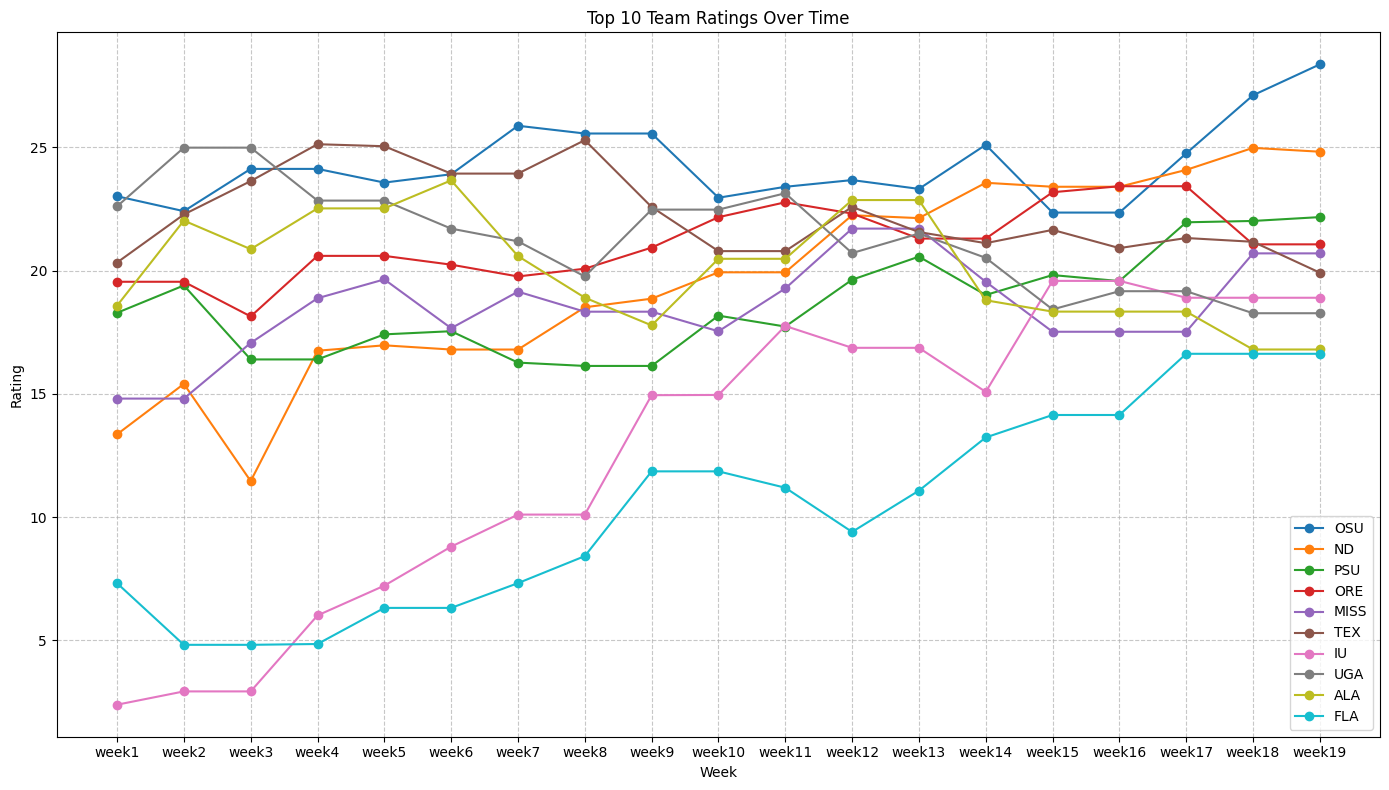

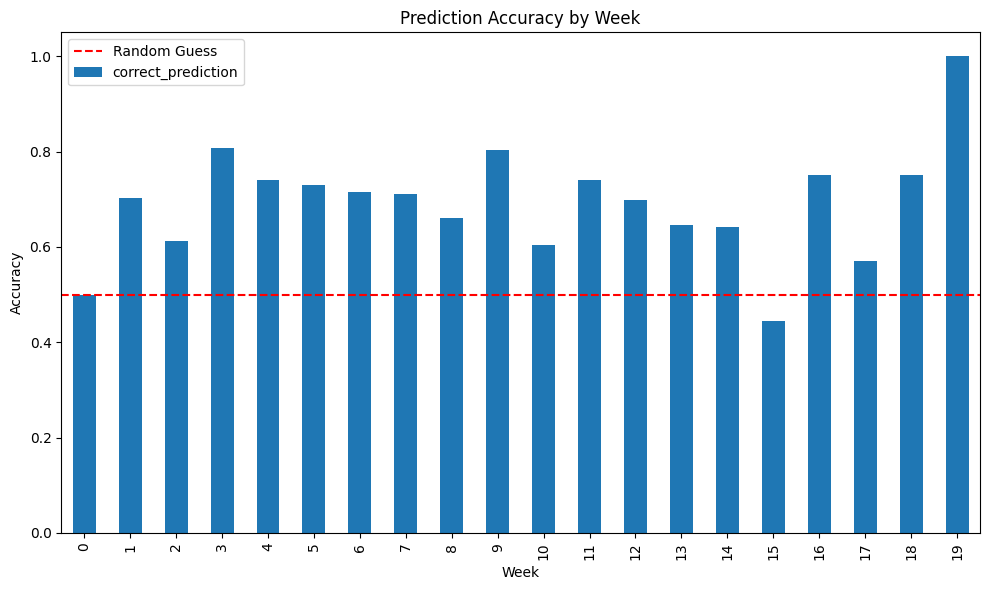

In [616]:
# Now run the system in a separate cell
# Initialize the team rating system
rating_system = TeamRatingSystem(
    prior_data=df_priors_2024,
    game_data=df_coll_impt_mdl_2024_playedtodate,
    teams_list=list_teams,
    regularization_strength=sides_lamb
)

# Calculate ratings for all weeks
max_week = 19  # Adjust as needed
df_ratings = rating_system.calculate_all_weeks(max_week)

# Display the ratings DataFrame
display(df_ratings.head())

# Initialize the prediction system
prediction_system = GamePredictionSystem(rating_system, df_spread_calc)

# Generate predictions for all games
df_predictions = prediction_system.generate_predictions(df_coll_impt_mdl_2024, max_week)

# Get predictions specifically for upcoming games
df_predictions_current = prediction_system.get_current_week_predictions(df_coll_impt_mdl_2024)

# Display current predictions
display(df_predictions_current)

# Visualization cell - Team ratings over time
plt.figure(figsize=(14, 8))
# Select top 10 teams based on latest ratings
top_teams = df_ratings.iloc[:, -1].sort_values(ascending=False).head(10).index

for team in top_teams:
    plt.plot(df_ratings.columns[1:], df_ratings.loc[team].values[1:], marker='o', label=team)

plt.title('Top 10 Team Ratings Over Time')
plt.xlabel('Week')
plt.ylabel('Rating')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization cell - Prediction accuracy (if you have actual results)
# Filter games that have been played
played_games = df_predictions.dropna(subset=["home_points"])

if len(played_games) > 0:
    # Calculate whether prediction was correct
    played_games["correct_prediction"] = (
        (played_games["home_points"] > played_games["away_points"]) & 
        (played_games["home_win_prob"] > 0.5)
    ) | (
        (played_games["home_points"] < played_games["away_points"]) & 
        (played_games["home_win_prob"] < 0.5)
    )
    
    # Group by week and calculate accuracy
    accuracy_by_week = played_games.groupby("week")["correct_prediction"].mean()
    
    plt.figure(figsize=(10, 6))
    accuracy_by_week.plot(kind='bar')
    plt.title('Prediction Accuracy by Week')
    plt.xlabel('Week')
    plt.ylabel('Accuracy')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Save results to CSV files
df_ratings.to_csv("team_ratings_2024.csv")
df_predictions.to_csv("all_game_predictions_2024.csv", index=False)
df_predictions_current.to_csv("current_week_predictions_2024.csv", index=False)

In [617]:
# Calculate MAE for all games up to and including week 12
results = calculate_mae_by_week(df_predictions, max_week=18)
print_mae_results(results)

# Calculate MAE for mid-season games only (weeks 5-10)
results_mid_season = calculate_mae_by_week(df_predictions, min_week=0, max_week=14)
print_mae_results(results_mid_season)


===== MAE RESULTS (Weeks 0 to 18) =====
Sample size: 781 games
Model MAE: 12.324
Market MAE: 12.129
Market outperforms model by 0.194 points

Weekly breakdown:
  Week 0: Model 18.519 vs Market 18.250 (2.0 games)
  Week 1: Model 12.986 vs Market 12.910 (37.0 games)
  Week 2: Model 13.422 vs Market 13.000 (49.0 games)
  Week 3: Model 13.976 vs Market 13.346 (52.0 games)
  Week 4: Model 12.124 vs Market 12.519 (54.0 games)
  Week 5: Model 12.373 vs Market 11.913 (52.0 games)
  Week 6: Model 13.170 vs Market 11.959 (49.0 games)
  Week 7: Model 11.352 vs Market 10.942 (52.0 games)
  Week 8: Model 11.631 vs Market 11.102 (59.0 games)
  Week 9: Model 11.940 vs Market 11.634 (56.0 games)
  Week 10: Model 13.710 vs Market 13.625 (48.0 games)
  Week 11: Model 11.531 vs Market 11.090 (50.0 games)
  Week 12: Model 11.929 vs Market 12.113 (53.0 games)
  Week 13: Model 11.430 vs Market 11.976 (62.0 games)
  Week 14: Model 11.590 vs Market 11.619 (67.0 games)
  Week 15: Model 20.092 vs Market 20.611 

C:\Users\nnich\AppData\Local\Temp\ipykernel_2304\1482249496.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_mae = df.groupby('week').apply(
C:\Users\nnich\AppData\Local\Temp\ipykernel_2304\1482249496.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_mae = df.groupby('week').apply(


In [618]:
df_optim=df_predictions[["model_spread", "actual_spread_capped" ,"home_close_line"]].copy()
df_optim["home_close_line"] = -1*df_optim["home_close_line"]

In [619]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load data and clean NaN values
df_optim = df_optim.dropna(subset=['model_spread', 'actual_spread_capped', 'home_close_line'])

# Convert to numeric (if not already)
df_optim['model_spread'] = pd.to_numeric(df_optim['model_spread'], errors='coerce')
df_optim['home_close_line'] = pd.to_numeric(df_optim['home_close_line'], errors='coerce')
df_optim = df_optim.dropna(subset=['model_spread', 'actual_spread_capped', 'home_close_line'])

# Extract cleaned data
model = df_optim['model_spread'].values
market = df_optim['home_close_line'].values
actual = df_optim['actual_spread_capped'].values

# Define objective function
def objective(weights, model, market, actual):
    a, b = weights
    combined = a * model + b * market
    mae = np.mean(np.abs(combined - actual))
    return mae

# Optimize with bounds to avoid invalid regions
result = minimize(
    objective,
    [0.5, 0.5],  # Initial guess
    args=(model, market, actual),
    method='L-BFGS-B',
    bounds=[(0, None), (0, None)]  # Non-negative weights
)

# Print results
if result.success:
    optimal_weights = result.x
    optimal_mae = result.fun
    print(f"Optimal weights - a (model): {optimal_weights[0]:.4f}, b (market): {optimal_weights[1]:.4f}")
    print(f"Minimum MAE: {optimal_mae:.4f}")
else:
    print("Optimization failed:", result.message)

Optimal weights - a (model): 0.0669, b (market): 0.9252
Minimum MAE: 12.1592


In [567]:
# Set up the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('D:\College Football\collegefootballratings-397413-82d6f79c90a1.json', scope)
client = gspread.authorize(creds)

# Open the document
sheet = client.open('CollegeFootballRatings')

# Try to get the "Predictions" worksheet
try:
    worksheet = sheet.worksheet("model_predictions")
    # Clear the content of the worksheet
    worksheet.clear()
except:
    # If "Predictions" worksheet doesn't exist, create it
    worksheet = sheet.add_worksheet(title="model_predictions", rows="100", cols="20")

# Upload the dataframe
set_with_dataframe(worksheet, df_predictions_current[["week", "home_team_code","away_team_code","home_team_rating","away_team_rating","home_adv","home_win_prob","model_spread","home_points","away_points","actual_spread"]])


In [156]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import set_with_dataframe

# Set up the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('D:\College Football\collegefootballratings-397413-82d6f79c90a1.json', scope)
client = gspread.authorize(creds)

# Open the document
sheet = client.open('CollegeFootballRatings')

# Try to get the "Ratings" worksheet
try:
    worksheet = sheet.worksheet("model_ratings")
    # Clear the content of the worksheet
    worksheet.clear()
except:
    # If "Ratings" worksheet doesn't exist, create it
    worksheet = sheet.add_worksheet(title="model_ratings", rows="100", cols="20")

# Upload the dataframe including its index
set_with_dataframe(worksheet, df_ratings, include_index=True)

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import set_with_dataframe

# Set up the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('D:\College Football\collegefootballratings-397413-82d6f79c90a1.json', scope)
client = gspread.authorize(creds)

# Open the document
sheet = client.open('CollegeFootballRatings')

# Try to get the "Ratings" worksheet
try:
    worksheet = sheet.worksheet("model_ratings_OLD")
    # Clear the content of the worksheet
    worksheet.clear()
except:
    # If "Ratings" worksheet doesn't exist, create it
    worksheet = sheet.add_worksheet(title="model_ratings_OLD", rows="100", cols="20")

# Upload the dataframe including its index
set_with_dataframe(worksheet, df_ratings_OLD, include_index=True)

In [ ]:
# Set up the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('D:\College Football\collegefootballratings-397413-82d6f79c90a1.json', scope)
client = gspread.authorize(creds)

# Open the document
sheet = client.open('CollegeFootballRatings')

# Try to get the "Predictions" worksheet
try:
    worksheet = sheet.worksheet("model_pastgames")
    # Clear the content of the worksheet
    worksheet.clear()
except:
    # If "Predictions" worksheet doesn't exist, create it
    worksheet = sheet.add_worksheet(title="model_pastgames", rows="100", cols="20")



# Upload the dataframe
set_with_dataframe(worksheet, df_coll_impt_mdl_2024_filter[~df_coll_impt_mdl_2024_filter["home_points"].isnull()])




In [221]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

def calculate_mae_by_week(predictions_df, max_week=None, min_week=None):
    """
    Calculate Mean Absolute Error for model and market predictions up to a specific week.
    
    Parameters:
    -----------
    predictions_df : pandas.DataFrame
        DataFrame containing predictions and actual results.
    max_week : int, optional
        The maximum week to include in calculations (inclusive).
    min_week : int, optional
        The minimum week to include in calculations (inclusive).
        
    Returns:
    --------
    dict
        Dictionary containing MAE values and other metrics.
    """
    # Create a copy of the dataframe
    df = predictions_df.copy()
    
    # Filter by week if specified
    if max_week is not None:
        df = df[df['week'] <= max_week]
    if min_week is not None:
        df = df[df['week'] >= min_week]
    
    # Filter out rows without actual results
    df = df.dropna(subset=['actual_spread_capped'])
    
    if len(df) == 0:
        return {
            'model_mae': None,
            'market_mae': None,
            'sample_size': 0,
            'weeks_included': []
        }
    
    # Calculate MAE for model predictions
    model_mae = mean_absolute_error(
        df["model_spread"], 
        df["actual_spread_capped"]
    )
    
    # Calculate MAE for market predictions (with model fallback for missing values)
    market_mae = mean_absolute_error(
        df["away_close_line"].fillna(df["model_spread"]), 
        df["actual_spread_capped"]
    )
    
    # Calculate additional metrics
    weekly_mae = df.groupby('week').apply(
        lambda x: pd.Series({
            'model_mae': mean_absolute_error(
                x["model_spread"], 
                x["actual_spread_capped"]
            ),
            'market_mae': mean_absolute_error(
                x["away_close_line"].fillna(x["model_spread"]), 
                x["actual_spread_capped"]
            ),
            'sample_size': len(x)
        })
    )
    
    # Create detailed results dictionary
    results = {
        'model_mae': model_mae,
        'market_mae': market_mae,
        'model_vs_market_diff': model_mae - market_mae,
        'sample_size': len(df),
        'weeks_included': sorted(df['week'].unique().tolist()),
        'weekly_breakdown': weekly_mae.to_dict(orient='index')
    }
    
    return results

def print_mae_results(results):
    """
    Print MAE results in a formatted way.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing MAE calculation results.
    """
    if results['sample_size'] == 0:
        print("No data available for the specified weeks.")
        return
    
    print(f"===== MAE RESULTS (Weeks {min(results['weeks_included'])} to {max(results['weeks_included'])}) =====")
    print(f"Sample size: {results['sample_size']} games")
    print(f"Model MAE: {results['model_mae']:.3f}")
    print(f"Market MAE: {results['market_mae']:.3f}")
    
    if results['model_mae'] < results['market_mae']:
        diff = results['market_mae'] - results['model_mae']
        print(f"Model outperforms market by {diff:.3f} points")
    else:
        diff = results['model_mae'] - results['market_mae']
        print(f"Market outperforms model by {diff:.3f} points")
    
    print("\nWeekly breakdown:")
    for week, metrics in sorted(results['weekly_breakdown'].items()):
        print(f"  Week {week}: Model {metrics['model_mae']:.3f} vs Market {metrics['market_mae']:.3f} ({metrics['sample_size']} games)")



In [776]:
df_coll_impt_mdl_2024_playedtodate.columns

Index(['date', 'id', 'week', 'venue', 'home_team_code', 'away_team_code',
       'home_points', 'away_points', 'neutral_site', 'home_rest_days_adv',
       'home_team_preseason_rating', 'away_team_preseason_rating',
       'actual_spread', 'team_code_x', 'home_timezone', 'team_code_y',
       'away_timezone', 'home_team_local_time', 'away_team_local_time',
       'home_team_optimal_time', 'away_team_optimal_time',
       'stadium_coordinates', 'stadium_timezone', 'stadium_local_time',
       'home_team_time_diff_hours', 'away_team_time_diff_hours',
       'home_team_hour_diff_adv', 'home_team_hour_diff_adv_adj',
       'home_rest_adj', 'base_home_adv', 'final_home_adv',
       'actual_spread_capped', 'game_id', 'epa_game_score', 'WEEK',
       'TEAM_home', 'TEAM_away', 'DATE', 'TIME', 'W_home', 'PF_home',
       'PA_home', 'OVER_home', 'OFF_home', 'PASS_home', 'PBLK_home',
       'RECV_home', 'RUN_home', 'RBLK_home', 'DEF_home', 'RDEF_home',
       'TACK_home', 'PRSH_home', 'COV_home',

In [804]:
total_blend_param=0
df_coll_impt_mdl_2024_playedtodate["actual_total"] = df_coll_impt_mdl_2024_playedtodate["home_points"] + df_coll_impt_mdl_2024_playedtodate["away_points"]
df_coll_impt_mdl_2024_playedtodate["blended_total"] = total_blend_param*(df_coll_impt_mdl_2024_playedtodate["home_points"] + df_coll_impt_mdl_2024_playedtodate["away_points"]) + (1-total_blend_param) *(df_coll_impt_mdl_2024_playedtodate["home_pff_score_model"].fillna(df_coll_impt_mdl_2024_playedtodate["home_points"])+ df_coll_impt_mdl_2024_playedtodate["away_pff_score_model"].fillna(df_coll_impt_mdl_2024_playedtodate["away_points"]))

In [805]:
df_coll_impt_mdl_2024_playedtodate[["actual_total","blended_total"]].corr()

,actual_total,blended_total
actual_total,1.000000,0.516929
blended_total,0.516929,1.000000


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

class SimpleTotalsRatingSystem:
    """
    Simplified system for calculating team total points ratings using ridge regression.
    """
    
    def __init__(self, game_data, teams_list, 
                 points_column_home="home_points", points_column_away="away_points",blended_total="blended_total",
                 mean_points_param=53.0, window_length=1, 
                 regularization_strength=8.0):
        self.game_data = game_data
        self.teams_list = teams_list
        self.points_column_home = points_column_home
        self.points_column_away = points_column_away
        self.blended_total = blended_total
        self.mean_points_param = mean_points_param
        self.window_length = window_length
        self.regularization_strength = regularization_strength
        
        # Initialize ratings DataFrame with preseason (week 0)
        self.ratings_df = pd.DataFrame(0.0, index=teams_list, columns=[0])  # Changed to 0.0 (float)

    def ridge_regression(self, X, y, prior):
        """Solve ridge regression with prior coefficients."""
        # Ensure all inputs are numerical arrays
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)
        prior = np.array(prior, dtype=float)
        
        return np.linalg.inv(X.T @ X + self.regularization_strength * np.eye(X.shape[1])) @ (X.T @ y + self.regularization_strength * prior)

    def calculate_team_ratings(self, week):
        """Calculate ratings for all teams based on recent games."""
        recent_games = self._filter_recent_games(week)
        
        if week <= 0 or recent_games.empty:
            return np.zeros(len(self.teams_list)), self.teams_list
        
        X = self._create_design_matrix(recent_games)
        y = (recent_games[self.blended_total] - self.mean_points_param).values
        prior = self._get_prior_ratings(week)
        
        return self.ridge_regression(X, y, prior), self.teams_list

    def _filter_recent_games(self, current_week):
        """Get games from the specified window."""
        start = max(0, current_week - self.window_length)
        end = current_week - 1
        mask = (self.game_data.week.between(start, end) & 
               self.game_data[[self.points_column_home, self.points_column_away]].notna().all(1))
        return self.game_data[mask]

    def _create_design_matrix(self, games_df):
        """Create team participation matrix using vectorized operations."""
        if games_df.empty:
            return np.zeros((0, len(self.teams_list)))
            
        stacked = games_df[['home_team_code', 'away_team_code']].stack()
        return pd.get_dummies(stacked, prefix='', prefix_sep='').groupby(level=0).max().reindex(columns=self.teams_list, fill_value=0).astype(float).values

    def _get_prior_ratings(self, week):
        """Get prior ratings from previous window."""
        prior_week = max(0, week - self.window_length)
        return self.ratings_df.get(prior_week, 0).values

    def calculate_all_weeks(self, max_week):
        """Calculate ratings for all weeks up to max_week."""
        for week in range(1, max_week + 1):
            ratings, _ = self.calculate_team_ratings(week)
            self.ratings_df[week] = pd.Series(ratings, index=self.teams_list)
        return self.ratings_df.rename(columns=lambda x: f'week{x}' if x != 0 else 'Preseason')

    def predict_totals(self, games_df):
        """Predict totals for given games using latest ratings."""
        games = games_df.copy()
        
        # Fixed the get_rating function to properly access team ratings
        def get_rating(team, week):
            valid_weeks = [w for w in self.ratings_df.columns if w <= week]
            return self.ratings_df.loc[team, max(valid_weeks)] if valid_weeks else 0
        
        games['home_rating'] = games.apply(lambda r: get_rating(r['home_team_code'], r['week']), axis=1)
        games['away_rating'] = games.apply(lambda r: get_rating(r['away_team_code'], r['week']), axis=1)
        games['predicted_total'] = games['home_rating'] + games['away_rating'] + self.mean_points_param
        return games

    def calculate_mae(self, predictions_df):
        """Calculate Mean Absolute Error for predictions."""
        # Create actual_total column by adding home and away points
        predictions_df['actual_total'] = predictions_df[self.points_column_home] + predictions_df[self.points_column_away]
        
        # Now filter to only include rows where we have actual scores
        df = predictions_df.dropna(subset=['actual_total'])
        if df.empty: return None
        
        mae = mean_absolute_error(df.actual_total, df.predicted_total)
        print(f"Model MAE: {mae:.2f} points (n={len(df)})")
        
        if 'over_under' in df.columns:
            market_mae = mean_absolute_error(df.actual_total, df.over_under.fillna(0))
            print(f"Market MAE: {market_mae:.2f} points")
            
        return mae


totals_system = SimpleTotalsRatingSystem(
    game_data=df_coll_impt_mdl_2024_playedtodate,
    teams_list=list_teams,
    regularization_strength=10,
    mean_points_param=53.0  # Adjust based on your league's average
)

# Calculate ratings for all weeks
df_total_ratings = totals_system.calculate_all_weeks(19)

# Generate predictions
df_predictions = totals_system.predict_totals(df_coll_impt_mdl_2024)

# Calculate MAE
totals_system.calculate_mae(df_predictions)

# Get upcoming games
current_week = df_coll_impt_mdl_2024[df_coll_impt_mdl_2024[['home_points', 'away_points']].isna().any(axis=1)]['week'].min()
upcoming_games = df_predictions[(df_predictions['week'] == current_week) & 
                               df_predictions[['home_points', 'away_points']].isna().any(axis=1)]

NameError: name 'df_coll_impt_mdl_2024_playedtodate' is not defined

In [ ]:
df = df_predictions.dropna(subset=['actual_total','Total'])
mean_absolute_error(df['actual_total'], df['Total'])

In [ ]:
df.shape

In [634]:
df_predictions[["date","id", "home_team_code", "away_team_code", "actual_spread_capped", "epa_game_score", "PFF_home_margin","predicted_total","actual_total"]].tail(50)

,date,id,home_team_code,away_team_code,actual_spread_capped,epa_game_score,PFF_home_margin,predicted_total,actual_total
732,2024-12-01 00:00:00+00:00,401628441,LSU,OKLA,20.0,8.832016,14.6,46.219273,54.0
733,2024-12-01 00:30:00+00:00,401628445,TAM,TEX,-10.0,-1.713259,-22.0,51.665514,24.0
734,2024-12-01 00:30:00+00:00,401628569,ORE,WASH,28.0,40.819102,35.6,46.697632,70.0
735,2024-12-01 00:30:00+00:00,401636944,ISU,KSU,8.0,-4.526399,-10.2,54.212526,50.0
736,2024-12-01 01:00:00+00:00,401635640,VT,UVA,20.0,11.723973,25.5,49.792236,54.0
737,2024-12-01 01:00:00+00:00,401643846,JMU,MRSH,-2.0,24.500151,-6.5,55.633378,68.0
738,2024-12-01 01:00:00+00:00,401643772,UNLV,NEV,24.0,32.691007,20.6,55.066184,52.0
739,2024-12-01 03:15:00+00:00,401636942,BYU,HOU,12.0,7.916251,13.2,40.746592,48.0
740,2024-12-01 03:30:00+00:00,401643768,SDSU,AFA,-11.0,3.784093,-13.5,43.995380,51.0
741,2024-12-01 04:00:00+00:00,401643771,HAW,UNM,8.0,-16.741413,15.9,59.349649,68.0


In [629]:
df_predictions[["date","id", "home_team_code", "away_team_code", "actual_spread_capped", "epa_game_score", "PFF_home_margin","blended_margin","model_spread"]].head(50)

KeyError: "['model_spread'] not in index"

In [623]:
df_coll_impt_mdl_2024_playedtodate[["date","id","WEEK", "home_team_code", "away_team_code", "actual_spread_capped", "epa_game_score", "PFF_home_margin","blended_margin"]].head(50)

,date,id,WEEK,home_team_code,away_team_code,actual_spread_capped,epa_game_score,PFF_home_margin,blended_margin
0,2024-08-24 16:00:00+00:00,401635525,0.0,GT,FSU,3.0,29.962249,3.2,7.084337
1,2024-08-25 00:00:00+00:00,401643696,0.0,NEV,SMU,-5.0,-13.065462,-9.9,-7.189819
2,2024-08-30 00:00:00+00:00,401640998,1.0,JSU,CCU,-28.0,-4.251811,-34.0,-25.637772
3,2024-08-30 00:00:00+00:00,401628448,1.0,MINN,UNC,-2.0,8.883701,-3.6,-0.687445
4,2024-08-30 23:00:00+00:00,401628453,1.0,MSU,FAU,6.0,9.845711,5.2,6.416857
5,2024-08-30 23:00:00+00:00,401628328,1.0,OKLA,TEM,48.0,24.197159,26.3,40.089574
6,2024-08-31 01:00:00+00:00,401628461,1.0,WIS,WMU,14.0,24.310308,15.5,15.846546
7,2024-08-31 02:30:00+00:00,401634300,1.0,STAN,TCU,-7.0,-8.483666,-11.2,-8.062550
8,2024-08-31 16:00:00+00:00,401628333,1.0,VAN,VT,7.0,15.638082,8.6,8.615712
9,2024-08-31 16:00:00+00:00,401628323,1.0,UGA,CLEM,31.0,15.938564,21.5,26.840785


In [809]:
df_coll_impt_mdl_2024_playedtodate["actual_spread"].mean()

4.8951406649616365